In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
import glob
import time
from moviepy.editor import VideoFileClip
%matplotlib inline

In [15]:
# Show first calibration image

images = glob.glob('./camera_cal/calibration*.jpg')

In [3]:
# Set up lists to hold object points and image points

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points. This is a 48x3 matrix
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

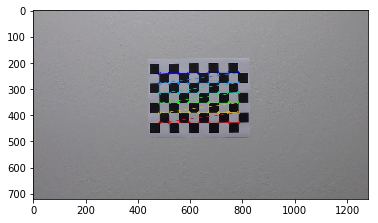

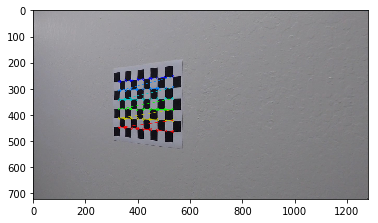

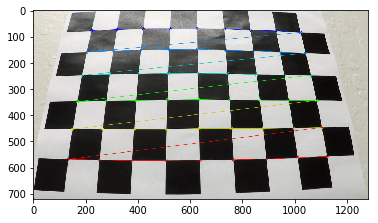

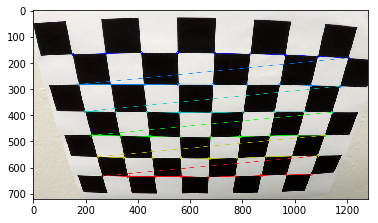

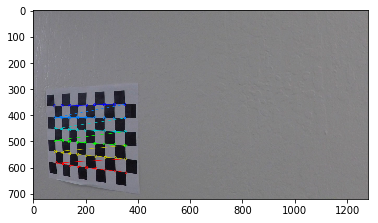

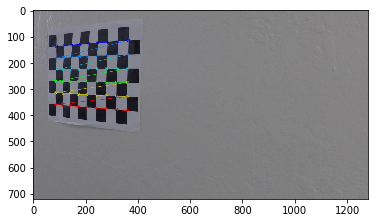

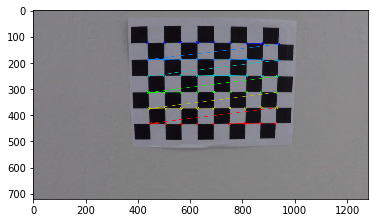

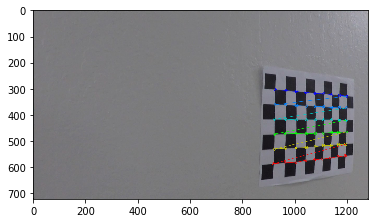

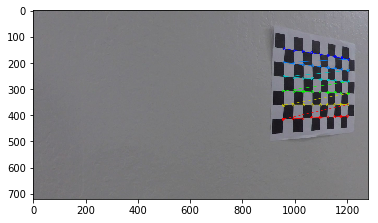

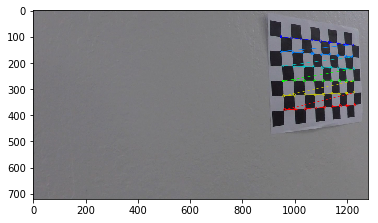

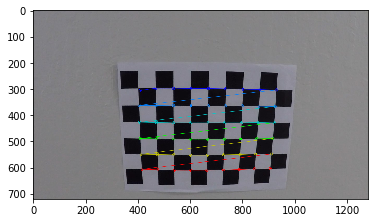

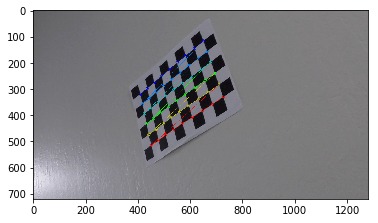

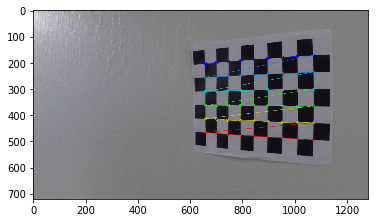

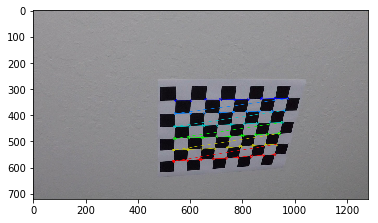

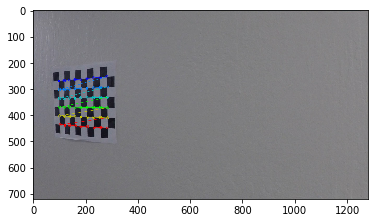

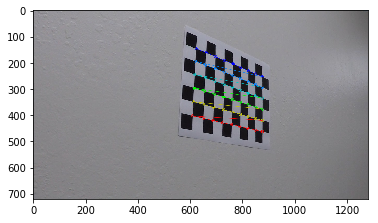

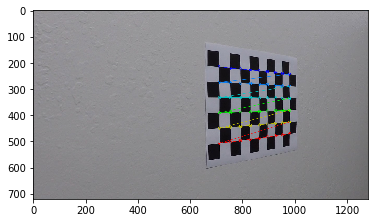

In [4]:
for fname in images:
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)

In [5]:
# Might want to change this so it isn't hardcoded
img_size = (1280, 720)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Return an undistorted image
def cal_undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

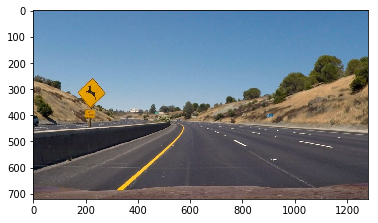

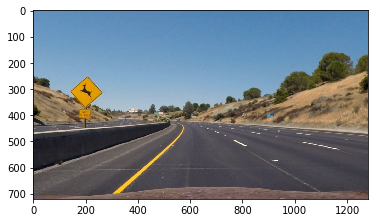

In [6]:
# Test the calibration for one image
#file = 'comma_example.jpg'
file = 'test2.jpg'
img = mpimg.imread('./test_images/' + file)
plt.imshow(img)

img = cal_undistort(img)

plt.figure()
plt.imshow(img)

In [7]:
def corners_unwarp(img):
    img_size = (img.shape[1], img.shape[0])

    src = np.float32([(575,460),
                  (710,460), 
                  (260,680), 
                  (1050,680)])
    dst = np.float32([(420,0),
                  (img_size[0]-420,0),
                  (420,img_size[1]),
                  (img_size[0]-420,img_size[1])])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

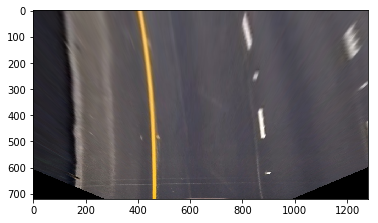

In [8]:
# Test the warping for a test image with a curved road
top_down, M, Minv = corners_unwarp(img)

plt.imshow(top_down)

In [9]:
def color_threshold(img, l_thresh=(220,255), b_thresh=(190,255)):
    img = np.copy(img)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    
    l_channel = hls[:,:,1]    
    lab_b = lab[:,:,2]

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Normalize if there is yellow in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    b_binary = np.zeros_like(lab_b)
    b_binary[(lab_b > b_thresh[0]) & (lab_b <= b_thresh[1])] = 1
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(b_binary == 1) | (l_binary == 1)] = 1
    
    return combined_binary
    

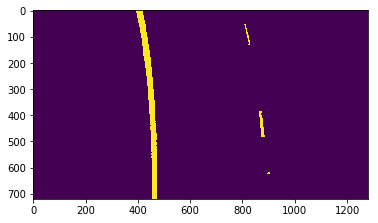

In [10]:
binary_warped = color_threshold(top_down)
plt.imshow(binary_warped)

In [11]:
# USE THIS TO PREPROCESS IMAGES
# RETURNS TOP DOWN BINARY IMAGE AND INVERSE MATRIX FOR UNDISTORTING

def preprocess(img):
    #undistorted = cal_undistort(img)
    
    top_down, M, Minv = corners_unwarp(img)
    
    binary_warped = color_threshold(top_down)
    
    return binary_warped, Minv


In [12]:
def polyfit(binary_warped, visualize=False):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if visualize:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, left_lane_inds, right_lane_inds

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


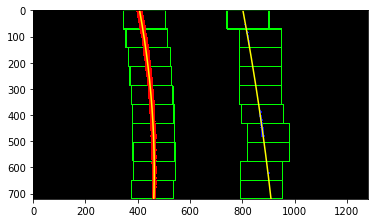

In [13]:
left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit(binary_warped, True)

In [14]:
def polyfit_prev(binary_warped, left_fit_prev, right_fit_prev, visualize=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if visualize:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

(1280, 720)


(array([ 5.95863264e-05, -9.63832437e-02,  4.90971431e+02]),
 array([ 1.46402934e-04, -1.39742354e-01,  9.24378544e+02]),
 array([False, False, False, ...,  True,  True,  True]),
 array([ True,  True,  True, ..., False, False, False]))

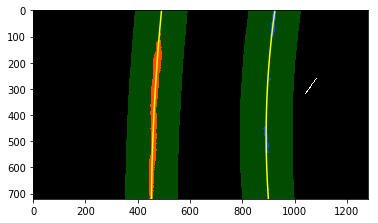

In [15]:
# Test the polyfit_prev function with a new image

img2 = mpimg.imread('./test_images/test4.jpg')

binary_warped2, Minv = preprocess(img2)

polyfit_prev(binary_warped2, left_fit, right_fit, True)

In [16]:
def draw_on_lane(img, binary_warped, left_fit, right_fit, Minv):
    new_img = np.copy(img)
    if left_fit is None or right_fit is None:
        return original_img
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, img_size[1]-1, num=img_size[1])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=20)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[0], img_size[1])) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

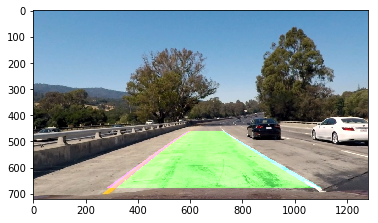

In [17]:
img_output = draw_on_lane(img, binary_warped, left_fit, right_fit, Minv)
plt.imshow(img_output)

In [18]:
def calculate_radius_and_distance(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_rad = 0
    right_rad = 0
    distance = 0
    
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    ploty = np.linspace(0, img_size[1]-1, img_size[1])
    y_eval = np.max(ploty)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) > 0 and len(rightx) > 0:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        left_rad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_rad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
    # Calculate how far the car is from the center of the lane
    if left_fit is not None and right_fit is not None:
        position = img_size[0] / 2
        left_x_intercept = left_fit[0]*img_size[1]**2 + left_fit[1]*img_size[1] + left_fit[2]
        right_x_intercept = right_fit[0]*img_size[1]**2 + right_fit[1]*img_size[1] + right_fit[2]
        lane_center = (left_x_intercept + right_x_intercept) / 2
                
        distance = (position - lane_center) * xm_per_pix
        
    return left_rad, right_rad, distance

In [19]:
left_rad, right_rad, distance = calculate_radius_and_distance(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

In [20]:
def draw_data(img, radius, distance):
    new_img = np.copy(img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(radius) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if distance > 0:
        direction = 'right'
    elif distance < 0:
        direction = 'left'
    abs_distance = abs(distance)
    text = '{:04.3f}'.format(abs_distance) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

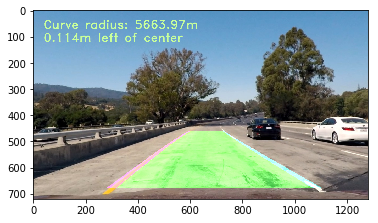

In [21]:
img_with_data = draw_data(img_output, (left_rad + right_rad)/2, distance)

plt.imshow(img_with_data)

In [22]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.recent_fits = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
    def add_fit(self, fit, inds):
        if fit is not None:
            if len(self.recent_fits) > 0:
                self.diffs = np.absolute(self.recent_fits[len(self.recent_fits)-1] - fit)
    
            if (self.diffs[0] > 0.01 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.recent_fits) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.recent_fits.append(fit)
                if len(self.recent_fits) > 5:
                    # Remove oldest fit
                    self.recent_fits.pop(0)
                self.best_fit = np.average(self.recent_fits, axis=0)
        else:
            self.detected = False

            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [46]:
preprocess_times = []
lane_detect_times = []

In [47]:
def process_image(img):

    new_img = np.copy(img)
    
    start = time.time()
    binary_warped, Minv = preprocess(new_img)
    end = time.time()
    
    preprocess_times.append(end - start)
    
    start = time.time()

    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit(binary_warped)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_prev(binary_warped, left_line.best_fit, right_line.best_fit)
        
    left_line.add_fit(left_fit, left_lane_inds)
    right_line.add_fit(right_fit, right_lane_inds)
    
    if left_line.best_fit is not None and right_line.best_fit is not None:
        left_rad, right_rad, distance = \
            calculate_radius_and_distance(binary_warped, left_line.best_fit, right_line.best_fit, left_lane_inds, right_lane_inds)
        
        output_img = draw_on_lane(new_img, binary_warped, left_line.best_fit, right_line.best_fit, Minv)
        output_img = draw_data(output_img, (left_rad+right_rad)/2, distance)
    else:
        output_img = new_img
        
    end = time.time()
    
    lane_detect_times.append(end - start)
        
    return output_img
    

In [48]:
left_line = Line()
right_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

(1280, 720)
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(1280, 720)
(1280, 720)


  0%|          | 2/1261 [00:00<01:47, 11.75it/s]

(1280, 720)


  0%|          | 4/1261 [00:00<01:37, 12.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  0%|          | 6/1261 [00:00<01:30, 13.80it/s]

(1280, 720)


  1%|          | 8/1261 [00:00<01:27, 14.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  1%|          | 10/1261 [00:00<01:25, 14.69it/s]

(1280, 720)


  1%|          | 12/1261 [00:00<01:22, 15.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  1%|          | 14/1261 [00:00<01:22, 15.06it/s]

(1280, 720)


  1%|▏         | 16/1261 [00:01<01:24, 14.74it/s]

(1280, 720)
(1280, 720)


  1%|▏         | 18/1261 [00:01<01:23, 14.96it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 20/1261 [00:01<01:20, 15.41it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 22/1261 [00:01<01:19, 15.59it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 24/1261 [00:01<01:18, 15.73it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 26/1261 [00:01<01:17, 15.86it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 28/1261 [00:01<01:17, 16.00it/s]

(1280, 720)
(1280, 720)


  2%|▏         | 30/1261 [00:01<01:16, 16.13it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 32/1261 [00:02<01:15, 16.31it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 34/1261 [00:02<01:14, 16.50it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 36/1261 [00:02<01:13, 16.62it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 38/1261 [00:02<01:12, 16.90it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 40/1261 [00:02<01:12, 16.90it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 42/1261 [00:02<01:11, 17.00it/s]

(1280, 720)
(1280, 720)


  3%|▎         | 44/1261 [00:02<01:14, 16.32it/s]

(1280, 720)
(1280, 720)


  4%|▎         | 46/1261 [00:02<01:18, 15.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 48/1261 [00:03<01:23, 14.44it/s]

(1280, 720)


  4%|▍         | 50/1261 [00:03<01:30, 13.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  4%|▍         | 52/1261 [00:03<01:32, 13.04it/s]

(1280, 720)
(1280, 720)


  4%|▍         | 54/1261 [00:03<01:37, 12.44it/s]

(1280, 720)


  4%|▍         | 56/1261 [00:03<01:33, 12.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▍         | 58/1261 [00:03<01:32, 12.97it/s]

(1280, 720)
(1280, 720)


  5%|▍         | 60/1261 [00:04<01:32, 13.02it/s]

(1280, 720)


  5%|▍         | 62/1261 [00:04<01:29, 13.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  5%|▌         | 66/1261 [00:04<01:24, 14.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  6%|▌         | 70/1261 [00:04<01:20, 14.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  6%|▌         | 74/1261 [00:04<01:20, 14.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  6%|▌         | 78/1261 [00:05<01:19, 14.85it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  6%|▋         | 80/1261 [00:05<01:20, 14.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 82/1261 [00:05<01:17, 15.15it/s]

(1280, 720)


  7%|▋         | 84/1261 [00:05<01:16, 15.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 86/1261 [00:05<01:16, 15.36it/s]

(1280, 720)


  7%|▋         | 88/1261 [00:05<01:15, 15.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 90/1261 [00:06<01:14, 15.63it/s]

(1280, 720)


  7%|▋         | 92/1261 [00:06<01:14, 15.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  7%|▋         | 94/1261 [00:06<01:13, 15.79it/s]

(1280, 720)


  8%|▊         | 96/1261 [00:06<01:14, 15.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 98/1261 [00:06<01:15, 15.40it/s]

(1280, 720)


  8%|▊         | 100/1261 [00:06<01:14, 15.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  8%|▊         | 102/1261 [00:06<01:14, 15.60it/s]

(1280, 720)


  8%|▊         | 104/1261 [00:06<01:16, 15.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)


  9%|▊         | 108/1261 [00:07<01:17, 14.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  9%|▉         | 112/1261 [00:07<01:15, 15.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


  9%|▉         | 116/1261 [00:07<01:13, 15.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 10%|▉         | 120/1261 [00:07<01:14, 15.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 10%|▉         | 124/1261 [00:08<01:17, 14.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 10%|█         | 128/1261 [00:08<01:17, 14.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 10%|█         | 132/1261 [00:08<01:14, 15.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 11%|█         | 136/1261 [00:09<01:12, 15.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 11%|█         | 140/1261 [00:09<01:14, 14.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 11%|█▏        | 144/1261 [00:09<01:14, 14.98it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 148/1261 [00:09<01:11, 15.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 152/1261 [00:10<01:10, 15.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 12%|█▏        | 156/1261 [00:10<01:09, 15.85it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 160/1261 [00:10<01:10, 15.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 164/1261 [00:10<01:09, 15.83it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 168/1261 [00:11<01:12, 15.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 13%|█▎        | 170/1261 [00:11<01:12, 14.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▍        | 174/1261 [00:11<01:10, 15.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▍        | 178/1261 [00:11<01:08, 15.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 14%|█▍        | 182/1261 [00:12<01:08, 15.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▍        | 186/1261 [00:12<01:08, 15.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▌        | 190/1261 [00:12<01:07, 15.85it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 15%|█▌        | 194/1261 [00:12<01:07, 15.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 196/1261 [00:12<01:10, 15.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 200/1261 [00:13<01:10, 15.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▌        | 204/1261 [00:13<01:08, 15.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 16%|█▋        | 208/1261 [00:13<01:06, 15.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 212/1261 [00:13<01:08, 15.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 216/1261 [00:14<01:07, 15.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 17%|█▋        | 220/1261 [00:14<01:06, 15.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 224/1261 [00:14<01:05, 15.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 228/1261 [00:14<01:07, 15.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 18%|█▊        | 232/1261 [00:15<01:08, 15.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▊        | 236/1261 [00:15<01:07, 15.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 240/1261 [00:15<01:05, 15.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 19%|█▉        | 244/1261 [00:16<01:05, 15.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 20%|█▉        | 248/1261 [00:16<01:04, 15.77it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 20%|█▉        | 252/1261 [00:16<01:02, 16.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 20%|██        | 256/1261 [00:16<01:02, 16.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 21%|██        | 260/1261 [00:17<01:02, 16.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 21%|██        | 264/1261 [00:17<01:03, 15.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 21%|██▏       | 268/1261 [00:17<01:02, 15.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 272/1261 [00:17<01:02, 15.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 276/1261 [00:18<01:02, 15.82it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 22%|██▏       | 280/1261 [00:18<01:04, 15.31it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 284/1261 [00:18<01:01, 15.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 288/1261 [00:18<01:02, 15.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 290/1261 [00:18<01:02, 15.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 23%|██▎       | 294/1261 [00:19<01:03, 15.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▎       | 298/1261 [00:19<01:01, 15.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▍       | 302/1261 [00:19<00:58, 16.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 24%|██▍       | 306/1261 [00:19<00:59, 16.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▍       | 310/1261 [00:20<00:59, 15.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▍       | 314/1261 [00:20<00:59, 15.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 25%|██▌       | 318/1261 [00:20<00:58, 16.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 322/1261 [00:20<00:59, 15.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 326/1261 [00:21<00:58, 15.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▌       | 330/1261 [00:21<00:58, 15.92it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 26%|██▋       | 334/1261 [00:21<00:57, 16.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 338/1261 [00:21<00:59, 15.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 342/1261 [00:22<00:58, 15.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 27%|██▋       | 346/1261 [00:22<00:59, 15.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 350/1261 [00:22<00:58, 15.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 354/1261 [00:22<00:56, 15.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 28%|██▊       | 358/1261 [00:23<00:57, 15.84it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▊       | 362/1261 [00:23<00:57, 15.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 366/1261 [00:23<00:56, 15.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 29%|██▉       | 370/1261 [00:23<00:54, 16.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 30%|██▉       | 374/1261 [00:24<00:56, 15.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 30%|██▉       | 378/1261 [00:24<00:56, 15.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 30%|███       | 382/1261 [00:24<00:56, 15.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 386/1261 [00:25<00:56, 15.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 390/1261 [00:25<00:56, 15.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 31%|███       | 394/1261 [00:25<00:56, 15.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 398/1261 [00:25<00:56, 15.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 402/1261 [00:26<00:54, 15.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 32%|███▏      | 406/1261 [00:26<00:54, 15.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 410/1261 [00:26<00:56, 15.03it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 412/1261 [00:26<00:56, 14.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 416/1261 [00:26<00:55, 15.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 33%|███▎      | 420/1261 [00:27<00:54, 15.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▎      | 424/1261 [00:27<00:54, 15.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 428/1261 [00:27<00:54, 15.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 34%|███▍      | 432/1261 [00:28<00:53, 15.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▍      | 436/1261 [00:28<00:54, 15.07it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▍      | 438/1261 [00:28<00:56, 14.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▌      | 442/1261 [00:28<00:57, 14.34it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 35%|███▌      | 444/1261 [00:28<00:57, 14.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 448/1261 [00:29<00:57, 14.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 452/1261 [00:29<00:55, 14.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▌      | 456/1261 [00:29<00:52, 15.21it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 36%|███▋      | 460/1261 [00:29<00:54, 14.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 464/1261 [00:30<00:51, 15.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 468/1261 [00:30<00:51, 15.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 37%|███▋      | 472/1261 [00:30<00:51, 15.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 476/1261 [00:30<00:50, 15.43it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 480/1261 [00:31<00:51, 15.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 38%|███▊      | 484/1261 [00:31<00:50, 15.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▊      | 488/1261 [00:31<00:50, 15.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▉      | 492/1261 [00:32<00:49, 15.59it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 39%|███▉      | 496/1261 [00:32<00:48, 15.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 40%|███▉      | 500/1261 [00:32<00:47, 15.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 40%|███▉      | 504/1261 [00:32<00:47, 15.87it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 40%|████      | 508/1261 [00:33<00:47, 16.02it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 512/1261 [00:33<00:46, 16.18it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 516/1261 [00:33<00:47, 15.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 41%|████      | 518/1261 [00:33<00:49, 15.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 41%|████▏     | 522/1261 [00:33<00:50, 14.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 526/1261 [00:34<00:49, 14.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 530/1261 [00:34<00:47, 15.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 42%|████▏     | 534/1261 [00:34<00:47, 15.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 538/1261 [00:35<00:46, 15.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 542/1261 [00:35<00:55, 12.90it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 544/1261 [00:35<00:52, 13.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 43%|████▎     | 548/1261 [00:35<00:52, 13.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 552/1261 [00:36<00:50, 14.06it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 556/1261 [00:36<00:48, 14.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 44%|████▍     | 558/1261 [00:36<00:49, 14.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▍     | 562/1261 [00:36<00:49, 14.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)

 45%|████▍     | 564/1261 [00:36<00:49, 14.06it/s]


(1280, 720)
(1280, 720)


 45%|████▌     | 568/1261 [00:37<00:49, 14.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 45%|████▌     | 572/1261 [00:37<00:47, 14.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 574/1261 [00:37<00:46, 14.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 578/1261 [00:37<00:45, 15.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▌     | 582/1261 [00:38<00:44, 15.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 46%|████▋     | 586/1261 [00:38<00:45, 14.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 590/1261 [00:38<00:45, 14.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 592/1261 [00:38<00:44, 15.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 47%|████▋     | 596/1261 [00:39<00:43, 15.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 600/1261 [00:39<00:42, 15.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 604/1261 [00:39<00:44, 14.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 606/1261 [00:39<00:44, 14.83it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 48%|████▊     | 610/1261 [00:40<00:44, 14.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▊     | 614/1261 [00:40<00:44, 14.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 618/1261 [00:40<00:44, 14.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 620/1261 [00:40<00:43, 14.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 49%|████▉     | 624/1261 [00:40<00:43, 14.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 50%|████▉     | 628/1261 [00:41<00:41, 15.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 50%|█████     | 632/1261 [00:41<00:41, 15.08it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 50%|█████     | 636/1261 [00:41<00:40, 15.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 640/1261 [00:42<00:41, 15.12it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████     | 644/1261 [00:42<00:40, 15.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 51%|█████▏    | 648/1261 [00:42<00:40, 14.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 652/1261 [00:42<00:40, 14.99it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 656/1261 [00:43<00:39, 15.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 52%|█████▏    | 660/1261 [00:43<00:39, 15.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 664/1261 [00:43<00:38, 15.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 668/1261 [00:43<00:37, 15.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 672/1261 [00:44<00:39, 14.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 53%|█████▎    | 674/1261 [00:44<00:39, 14.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 678/1261 [00:44<00:38, 15.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 682/1261 [00:44<00:38, 14.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 54%|█████▍    | 686/1261 [00:45<00:39, 14.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▍    | 688/1261 [00:45<00:38, 14.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▍    | 692/1261 [00:45<00:37, 15.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 55%|█████▌    | 696/1261 [00:45<00:36, 15.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▌    | 700/1261 [00:45<00:35, 15.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▌    | 704/1261 [00:46<00:35, 15.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▌    | 708/1261 [00:46<00:35, 15.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 56%|█████▋    | 712/1261 [00:46<00:34, 15.78it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 716/1261 [00:46<00:34, 15.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 720/1261 [00:47<00:34, 15.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 57%|█████▋    | 724/1261 [00:47<00:33, 16.05it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 728/1261 [00:47<00:33, 16.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 732/1261 [00:47<00:32, 16.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 58%|█████▊    | 736/1261 [00:48<00:32, 15.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▊    | 740/1261 [00:48<00:32, 16.00it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 744/1261 [00:48<00:32, 15.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 59%|█████▉    | 748/1261 [00:48<00:32, 15.98it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|█████▉    | 752/1261 [00:49<00:32, 15.69it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|█████▉    | 756/1261 [00:49<00:32, 15.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 60%|██████    | 760/1261 [00:49<00:32, 15.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 764/1261 [00:50<00:32, 15.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 768/1261 [00:50<00:31, 15.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 61%|██████    | 772/1261 [00:50<00:31, 15.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 776/1261 [00:50<00:31, 15.48it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 780/1261 [00:51<00:31, 15.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 784/1261 [00:51<00:30, 15.56it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 62%|██████▏   | 788/1261 [00:51<00:30, 15.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 792/1261 [00:51<00:30, 15.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 796/1261 [00:52<00:29, 15.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 63%|██████▎   | 800/1261 [00:52<00:28, 16.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 804/1261 [00:52<00:28, 16.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 808/1261 [00:52<00:28, 15.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 64%|██████▍   | 812/1261 [00:53<00:27, 16.11it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▍   | 816/1261 [00:53<00:28, 15.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▍   | 818/1261 [00:53<00:28, 15.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 65%|██████▌   | 822/1261 [00:53<00:29, 14.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 826/1261 [00:54<00:28, 15.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 830/1261 [00:54<00:27, 15.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▌   | 834/1261 [00:54<00:27, 15.75it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 66%|██████▋   | 838/1261 [00:54<00:26, 15.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 842/1261 [00:55<00:27, 15.37it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 846/1261 [00:55<00:27, 15.23it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 67%|██████▋   | 850/1261 [00:55<00:27, 15.14it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 854/1261 [00:55<00:26, 15.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 858/1261 [00:56<00:26, 15.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 68%|██████▊   | 862/1261 [00:56<00:26, 15.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▊   | 866/1261 [00:56<00:25, 15.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▉   | 870/1261 [00:56<00:25, 15.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 69%|██████▉   | 874/1261 [00:57<00:24, 15.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 70%|██████▉   | 878/1261 [00:57<00:25, 15.30it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 70%|██████▉   | 882/1261 [00:57<00:24, 15.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 70%|███████   | 886/1261 [00:57<00:24, 15.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 890/1261 [00:58<00:24, 15.42it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 894/1261 [00:58<00:23, 15.68it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 71%|███████   | 898/1261 [00:58<00:23, 15.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 902/1261 [00:58<00:23, 15.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 906/1261 [00:59<00:22, 15.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 910/1261 [00:59<00:21, 15.97it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 72%|███████▏  | 914/1261 [00:59<00:21, 15.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 918/1261 [00:59<00:22, 15.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 920/1261 [01:00<00:21, 15.65it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 73%|███████▎  | 924/1261 [01:00<00:21, 15.76it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▎  | 928/1261 [01:00<00:22, 14.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 932/1261 [01:00<00:21, 15.58it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 74%|███████▍  | 936/1261 [01:01<00:21, 14.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▍  | 940/1261 [01:01<00:20, 15.41it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▍  | 944/1261 [01:01<00:21, 14.76it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 948/1261 [01:01<00:20, 15.09it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 75%|███████▌  | 952/1261 [01:02<00:20, 14.96it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▌  | 956/1261 [01:02<00:20, 14.86it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▌  | 960/1261 [01:02<00:19, 15.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 76%|███████▋  | 964/1261 [01:03<00:19, 15.38it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 968/1261 [01:03<00:19, 15.16it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 972/1261 [01:03<00:18, 15.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 77%|███████▋  | 976/1261 [01:03<00:18, 15.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 980/1261 [01:04<00:17, 15.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 984/1261 [01:04<00:17, 16.25it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 78%|███████▊  | 988/1261 [01:04<00:16, 16.10it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▊  | 992/1261 [01:04<00:17, 15.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 996/1261 [01:05<00:16, 15.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 79%|███████▉  | 1000/1261 [01:05<00:16, 15.73it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 80%|███████▉  | 1004/1261 [01:05<00:16, 15.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 80%|███████▉  | 1006/1261 [01:05<00:16, 15.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 80%|████████  | 1010/1261 [01:05<00:16, 14.95it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 80%|████████  | 1014/1261 [01:06<00:16, 14.72it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 1016/1261 [01:06<00:16, 14.60it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 1018/1261 [01:06<00:16, 14.54it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████  | 1022/1261 [01:06<00:16, 14.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 81%|████████▏ | 1026/1261 [01:07<00:16, 14.47it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1030/1261 [01:07<00:15, 14.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1034/1261 [01:07<00:14, 15.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 82%|████████▏ | 1038/1261 [01:07<00:14, 15.04it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 83%|████████▎ | 1042/1261 [01:08<00:14, 15.32it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 83%|████████▎ | 1046/1261 [01:08<00:14, 14.98it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 83%|████████▎ | 1050/1261 [01:08<00:13, 15.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▎ | 1054/1261 [01:08<00:13, 14.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▎ | 1056/1261 [01:09<00:13, 14.80it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▍ | 1060/1261 [01:09<00:13, 14.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 84%|████████▍ | 1064/1261 [01:09<00:13, 14.94it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▍ | 1068/1261 [01:09<00:13, 14.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▍ | 1070/1261 [01:10<00:13, 14.45it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▌ | 1074/1261 [01:10<00:13, 13.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 85%|████████▌ | 1076/1261 [01:10<00:13, 13.88it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1080/1261 [01:10<00:13, 13.71it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1082/1261 [01:10<00:13, 13.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▌ | 1086/1261 [01:11<00:12, 13.93it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 86%|████████▋ | 1090/1261 [01:11<00:12, 14.22it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1094/1261 [01:11<00:11, 14.26it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1096/1261 [01:11<00:11, 14.24it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 87%|████████▋ | 1100/1261 [01:12<00:10, 14.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1104/1261 [01:12<00:10, 15.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1108/1261 [01:12<00:09, 15.44it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 88%|████████▊ | 1112/1261 [01:12<00:09, 15.91it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▊ | 1116/1261 [01:13<00:09, 15.64it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1120/1261 [01:13<00:09, 15.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1124/1261 [01:13<00:09, 15.13it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 89%|████████▉ | 1128/1261 [01:13<00:08, 15.01it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 90%|████████▉ | 1132/1261 [01:14<00:08, 15.40it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 90%|█████████ | 1136/1261 [01:14<00:07, 15.79it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 90%|█████████ | 1140/1261 [01:14<00:07, 15.63it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1144/1261 [01:15<00:07, 15.49it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████ | 1148/1261 [01:15<00:07, 15.61it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 91%|█████████▏| 1152/1261 [01:15<00:06, 15.89it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1156/1261 [01:15<00:06, 15.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1160/1261 [01:16<00:06, 15.39it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 92%|█████████▏| 1164/1261 [01:16<00:06, 15.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1168/1261 [01:16<00:05, 15.70it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1172/1261 [01:16<00:05, 15.74it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 93%|█████████▎| 1176/1261 [01:17<00:05, 15.52it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▎| 1180/1261 [01:17<00:05, 15.34it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 1184/1261 [01:17<00:04, 15.50it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 94%|█████████▍| 1188/1261 [01:17<00:04, 15.57it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▍| 1192/1261 [01:18<00:04, 15.66it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▍| 1196/1261 [01:18<00:04, 15.20it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▌| 1200/1261 [01:18<00:03, 15.35it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 95%|█████████▌| 1204/1261 [01:18<00:03, 15.29it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▌| 1208/1261 [01:19<00:03, 15.81it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▌| 1212/1261 [01:19<00:03, 15.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 96%|█████████▋| 1216/1261 [01:19<00:02, 15.33it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1220/1261 [01:19<00:02, 15.36it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1222/1261 [01:20<00:02, 15.27it/s]

(1280, 720)
(1280, 720)
(1280, 720)


 97%|█████████▋| 1226/1261 [01:20<00:02, 15.15it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1230/1261 [01:20<00:02, 15.39it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1234/1261 [01:20<00:01, 15.19it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1238/1261 [01:21<00:01, 15.17it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 98%|█████████▊| 1242/1261 [01:21<00:01, 15.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 1246/1261 [01:21<00:00, 15.62it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 1250/1261 [01:21<00:00, 15.51it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


 99%|█████████▉| 1254/1261 [01:22<00:00, 15.28it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


100%|█████████▉| 1258/1261 [01:22<00:00, 15.55it/s]

(1280, 720)
(1280, 720)
(1280, 720)
(1280, 720)


100%|█████████▉| 1260/1261 [01:22<00:00, 15.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 45s, sys: 1.96 s, total: 1min 47s
Wall time: 1min 23s


In [49]:
# Preprocess for testing document
# images = get_all_images_from('./testing_images') this is pseudocode

# for image in images:
#     output, Minv = preprocess(image)
#     plt.imshow(output)

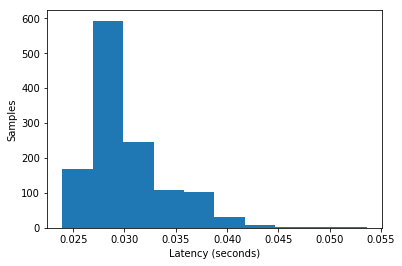

0.03022917332297559


In [60]:
fig, ax = plt.subplots()
ax.hist(lane_detect_times)
ax.set_xlabel("Latency (seconds)")
ax.set_ylabel("Samples")
plt.show()
print(np.average(lane_detect_times))